# About
LSTM and Bi-Directional LSTMs based sentiment analysis on twitter dataset.

In [1]:
#importing modules
import os
import pandas as pd
import seaborn as sns
import os
import shutil
import tensorflow.keras as keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,TimeDistributed, Flatten, Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
import matplotlib.pyplot as plt
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
import re

In [2]:
!nvidia-smi

Thu Apr  1 16:36:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Dataset/TwitterSentimentAnalysis')

In [4]:
!ls

sample_submission.csv  test.csv  train.csv  tweet-sentiment-extraction.zip


In [5]:
#!unzip tweet-sentiment-extraction.zip

In [6]:
train_dataset = pd.read_csv('train.csv')
test_dataset = pd.read_csv('test.csv')

In [7]:
train_dataset.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [8]:
train_dataset.tail()

,textID,text,selected_text,sentiment
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive
27480,6f7127d9d7,All this flirting going on - The ATG smiles...,All this flirting going on - The ATG smiles. Y...,neutral


In [9]:
train_dataset.shape

(27481, 4)

In [10]:
#checking if there are any null values
train_dataset.isnull().any()

textID           False
text              True
selected_text     True
sentiment        False
dtype: bool

In [11]:
#checking out number of negative, neutral and positive sentiment labels in the dataset.
print("Number of positive sentiment in train data of length: {0} is {1}".format(len(train_dataset), len(train_dataset[train_dataset['sentiment']=="positive"])))
print("Number of negative sentiment in train data of length: {0} is {1}".format(len(train_dataset), len(train_dataset[train_dataset['sentiment']=="neutral"])))
print("Number of neutral sentiment in train data of length: {0} is {1}".format(len(train_dataset), len(train_dataset[train_dataset['sentiment']=="negative"])))

Number of positive sentiment in train data of length: 27481 is 8582
Number of negative sentiment in train data of length: 27481 is 11118
Number of neutral sentiment in train data of length: 27481 is 7781


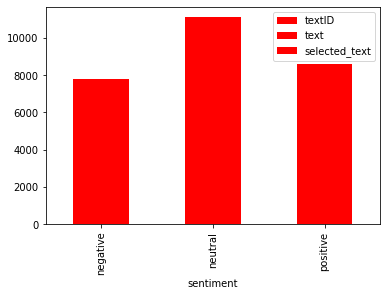

In [12]:
#plotting the same.
train_dataset.groupby('sentiment').count().plot.bar(color='red')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


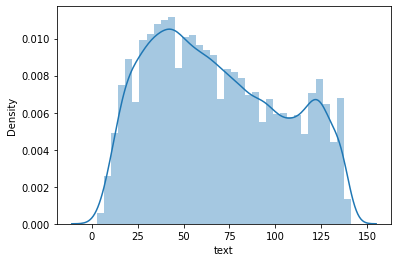

In [13]:
#plotting the distibution of number of characters in the tweets
sns.distplot(train_dataset.text.str.len())

In [14]:
#dropping unneccessary columns
train_dataset = train_dataset.drop(['textID','selected_text'],axis=1)
train_dataset.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


# Tokenisation

In [21]:
#converting data in text column to string 
train_dataset.text=train_dataset.text.astype(str)
#removing neutral categories
train_dataset_without_neutral = train_dataset[train_dataset.sentiment!="neutral"]
train_dataset_without_neutral.text=train_dataset_without_neutral.text.astype(str)
#converting train_dataset and train_dataset_without neutral to lower case
train_dataset.text = train_dataset.text.str.lower()
train_dataset_without_neutral.text = train_dataset_without_neutral.text.str.lower()
#cleaning more
train_dataset['text'] = train_dataset['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
train_dataset_without_neutral['text'] = train_dataset_without_neutral['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


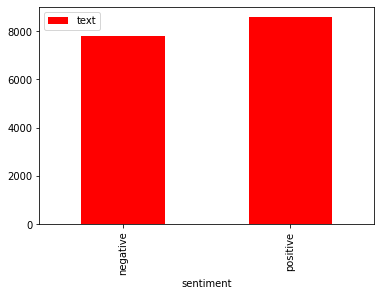

In [22]:
train_dataset_without_neutral.groupby('sentiment').count().plot.bar(color='red')

In [23]:
max_features = 5000
# removing unneccessary punctuations while tokenizing
tokenizer = Tokenizer(num_words= max_features, oov_token='OOV',filters='!"#$%&()*+,-./:;<=>@[\]^_`{|}~')
tokenizer.fit_on_texts(train_dataset['text'].values)
features = tokenizer.texts_to_sequences(train_dataset['text'].values)
features = pad_sequences(features,padding='post')

In [24]:
max_features = 5000
# removing unneccessary punctuations while tokenizing
tokenizer2 = Tokenizer(num_words= max_features, oov_token='OOV',filters='!"#$%&()*+,-./:;<=>@[\]^_`{|}~')
tokenizer2.fit_on_texts(train_dataset_without_neutral['text'].values)
features2 = tokenizer2.texts_to_sequences(train_dataset_without_neutral['text'].values)
features2 = pad_sequences(features2,padding='post')

In [25]:
#getting numerical data for labels
labels = pd.get_dummies(train_dataset['sentiment']).values
X_train, X_val, Y_train, Y_val = train_test_split(features,labels, test_size = 0.33, random_state = 42)
X_train, X_val, Y_train, Y_val = train_test_split(features,labels, test_size = 0.33, random_state = 42)

print("Input training features and label shape are {},{}".format(X_train.shape,Y_train.shape))
print("Input validation features and label shape are {}, {}".format(X_val.shape,Y_val.shape))


Input training features and label shape are (18412, 34),(18412, 3)
Input validation features and label shape are (9069, 34), (9069, 3)


In [26]:
#getting numerical data for labels
labels1 = pd.get_dummies(train_dataset_without_neutral['sentiment']).values
X_train1, X_val1, Y_train1, Y_val1 = train_test_split(features2,labels1, test_size = 0.33, random_state = 42)

print("Input training features and label shape are {},{}".format(X_train1.shape,Y_train1.shape))
print("Input validation features and label shape are {}, {}".format(X_val1.shape,Y_val1.shape))


Input training features and label shape are (10963, 33),(10963, 2)
Input validation features and label shape are (5400, 33), (5400, 2)


# Model architecture 
A. LSTM.


In [29]:
embedding_dimension = 128
LSTM_model = Sequential()
LSTM_model.add(Embedding(max_features, embedding_dimension, input_length = features.shape[1]))
LSTM_model.add(SpatialDropout1D(0.4))
LSTM_model.add(LSTM(128, kernel_regularizer=l2(0.1),  dropout=0.4,recurrent_dropout=0.4))
LSTM_model.add(Dense(3, activation='softmax'))
LSTM_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 34, 128)           640000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 34, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 771,971
Trainable params: 771,971
Non-trainable params: 0
_________________________________________________________________


In [37]:
embedding_dimension = 128
LSTM_model_binary = Sequential()
LSTM_model_binary.add(Embedding(max_features, embedding_dimension, input_length = features.shape[1]))
LSTM_model_binary.add(SpatialDropout1D(0.4))
LSTM_model_binary.add(LSTM(128, kernel_regularizer=l2(0.1),  dropout=0.4,recurrent_dropout=0.4))
LSTM_model_binary.add(Dense(2, activation='softmax'))
LSTM_model_binary.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
LSTM_model_binary.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 34, 128)           640000    
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 34, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 258       
Total params: 771,842
Trainable params: 771,842
Non-trainable params: 0
_________________________________________________________________


# Model training stage.


In [39]:
batch_size = 256
LSTM_model_history = LSTM_model.fit(X_train,Y_train, epochs = 50, batch_size=batch_size, verbose=1, shuffle=True,validation_data=(X_val,Y_val))

Epoch 1/50
72/72 [==============================] - 11s 151ms/step - loss: 0.4798 - accuracy: 0.8222 - val_loss: 1.0058 - val_accuracy: 0.6514
Epoch 2/50
72/72 [==============================] - 11s 155ms/step - loss: 0.4713 - accuracy: 0.8261 - val_loss: 1.0649 - val_accuracy: 0.6549
Epoch 3/50
72/72 [==============================] - 11s 155ms/step - loss: 0.4626 - accuracy: 0.8303 - val_loss: 1.0058 - val_accuracy: 0.6544
Epoch 4/50
72/72 [==============================] - 11s 148ms/step - loss: 0.4706 - accuracy: 0.8252 - val_loss: 1.0378 - val_accuracy: 0.6589
Epoch 5/50
72/72 [==============================] - 11s 155ms/step - loss: 0.4645 - accuracy: 0.8279 - val_loss: 1.0577 - val_accuracy: 0.6555
Epoch 6/50
72/72 [==============================] - 11s 151ms/step - loss: 0.4568 - accuracy: 0.8302 - val_loss: 1.0651 - val_accuracy: 0.6430
Epoch 7/50
72/72 [==============================] - 11s 152ms/step - loss: 0.4635 - accuracy: 0.8290 - val_loss: 0.9665 - val_accuracy: 0.6545

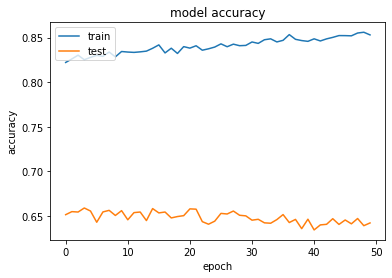

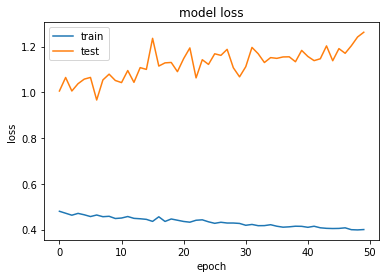

In [42]:
plt.plot(LSTM_model_history.history['accuracy'])
plt.plot(LSTM_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(LSTM_model_history.history['loss'])
plt.plot(LSTM_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Observation::
Let's try on binary classes by removing neutral ones to have more polarity in the sentiments.

In [38]:
batch_size = 256
LSTM_model_binary_history = LSTM_model_binary.fit(X_train1,Y_train1, epochs = 50, batch_size=batch_size, verbose=1, shuffle=True,validation_data=(X_val1,Y_val1))

Epoch 1/50
43/43 [==============================] - 9s 156ms/step - loss: 15.7217 - accuracy: 0.5316 - val_loss: 4.9553 - val_accuracy: 0.5572
Epoch 2/50
43/43 [==============================] - 6s 151ms/step - loss: 3.5048 - accuracy: 0.6886 - val_loss: 1.0255 - val_accuracy: 0.8172
Epoch 3/50
43/43 [==============================] - 7s 153ms/step - loss: 0.7675 - accuracy: 0.8542 - val_loss: 0.4213 - val_accuracy: 0.8530
Epoch 4/50
43/43 [==============================] - 7s 155ms/step - loss: 0.3446 - accuracy: 0.8875 - val_loss: 0.3833 - val_accuracy: 0.8533
Epoch 5/50
43/43 [==============================] - 7s 152ms/step - loss: 0.2599 - accuracy: 0.9068 - val_loss: 0.3827 - val_accuracy: 0.8413
Epoch 6/50
43/43 [==============================] - 6s 151ms/step - loss: 0.2516 - accuracy: 0.9132 - val_loss: 0.3688 - val_accuracy: 0.8465
Epoch 7/50
43/43 [==============================] - 7s 154ms/step - loss: 0.2295 - accuracy: 0.9221 - val_loss: 0.3532 - val_accuracy: 0.8581
Epoch

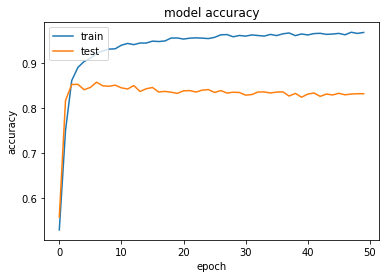

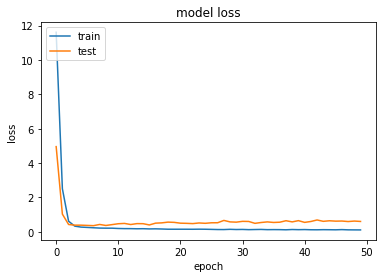

In [40]:
plt.plot(LSTM_model_binary_history.history['accuracy'])
plt.plot(LSTM_model_binary_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(LSTM_model_binary_history.history['loss'])
plt.plot(LSTM_model_binary_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Observation
Let's try Bidirectional LSTMs.

# 2. Using BiDirectional LSTMs.

In [57]:
vocab_size = len(tokenizer.word_index)+1 # 1 for that extra OOV

In [70]:
# main model
BiLSTM = Sequential()
BiLSTM.add(Embedding(vocab_size,100,input_length = features2.shape[1]))
BiLSTM.add(Bidirectional (LSTM (100,return_sequences=True,dropout=0.2,recurrent_dropout=0.2, kernel_regularizer=l2(0.1)),merge_mode='concat'))
BiLSTM.add(TimeDistributed(Dense(100,activation='relu')))
BiLSTM.add(SpatialDropout1D(0.4))
BiLSTM.add(Flatten())
BiLSTM.add(Dense(2,activation='softmax'))
BiLSTM.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [71]:
BiLSTM.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 33, 100)           2873100   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 33, 200)           160800    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 33, 100)           20100     
_________________________________________________________________
spatial_dropout1d_10 (Spatia (None, 33, 100)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3300)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 6602      
Total params: 3,060,602
Trainable params: 3,060,602
Non-trainable params: 0
___________________________________________

In [72]:
batch_size = 256
BiLSTM_model_history = BiLSTM.fit(X_train1,Y_train1, epochs = 50, batch_size=batch_size, verbose=1, validation_data=(X_val1,Y_val1))

Epoch 1/50
43/43 [==============================] - 17s 298ms/step - loss: 24.9399 - accuracy: 0.5337 - val_loss: 8.7075 - val_accuracy: 0.7948
Epoch 2/50
43/43 [==============================] - 12s 287ms/step - loss: 6.3374 - accuracy: 0.8304 - val_loss: 2.0176 - val_accuracy: 0.8443
Epoch 3/50
43/43 [==============================] - 12s 291ms/step - loss: 1.4028 - accuracy: 0.9055 - val_loss: 0.6272 - val_accuracy: 0.8435
Epoch 4/50
43/43 [==============================] - 12s 280ms/step - loss: 0.3976 - accuracy: 0.9237 - val_loss: 0.4234 - val_accuracy: 0.8546
Epoch 5/50
43/43 [==============================] - 12s 286ms/step - loss: 0.2080 - accuracy: 0.9388 - val_loss: 0.3995 - val_accuracy: 0.8489
Epoch 6/50
43/43 [==============================] - 12s 286ms/step - loss: 0.1775 - accuracy: 0.9468 - val_loss: 0.4602 - val_accuracy: 0.8344
Epoch 7/50
43/43 [==============================] - 12s 288ms/step - loss: 0.1670 - accuracy: 0.9468 - val_loss: 0.4276 - val_accuracy: 0.841

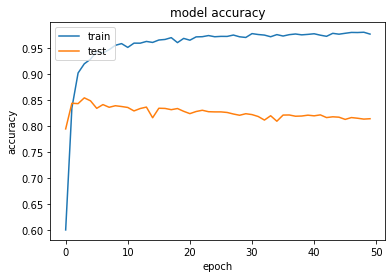

In [73]:
plt.plot(BiLSTM_model_history.history['accuracy'])
plt.plot(BiLSTM_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


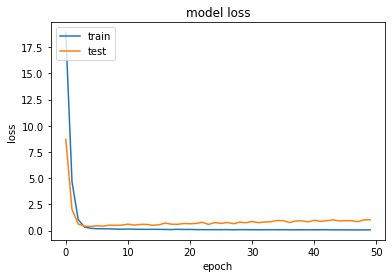

In [74]:
# summarize history for loss
plt.plot(BiLSTM_model_history.history['loss'])
plt.plot(BiLSTM_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [75]:
#saving the trained sentiment detection model
BiLSTM.save('SentimentDetection_BiLSTM.h5')

In [80]:
#let's predict on a few examples
import numpy as np
input_text = ["Hello there!, It's such an awesome day, Hope you are doing good"]
input_features = tokenizer.texts_to_sequences(input_text)
input_features = pad_sequences(input_features,padding='post')
class_prob = LSTM_model.predict(input_features, batch_size=1)[0]
if np.argmax(class_prob)==0:
  print("Negative Sentiment")
else:
  print("Positive Sentiment")

Positive Sentiment
